In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pylab import rcParams

rcParams['figure.figsize'] = 12, 6
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

In [2]:
first_letters =  'ABCDEF'
second_numbers = '120'
last_letters = 'QWOPZXML'

# returns a string of the following format: [4 letters A-F][1 digit 0-2][3 letters QWOPZXML]
def get_random_string():
    str1 = ''.join(random.choice(first_letters) for i in range(4))
    str2 = random.choice(second_numbers)
    str3 = ''.join(random.choice(last_letters) for i in range(3))
    return str1+str2+str3
    
print(get_random_string())

EECC2ZZW


In [3]:
# get 25,000 sequences of this format
random_sequences = [get_random_string() for i in range(25000)]
random_sequences[1:5]

['CBFE1WWL', 'DCCD2OWM', 'CFAC0POW', 'FACC2ZLW']

In [4]:

#Build the char index that we will use to encode seqs to numbers
char_index = '0abcdefghijklmnopqrstuvwxyz'
char_index +='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
char_index += '123456789'
char_index += '().,-/+=&$?@#!*:;_[]|%⸏{}\"\'' + ' ' +'\\'

char_to_int = dict((c, i) for i, c in enumerate(char_index))
int_to_char = dict((i, c) for i, c in enumerate(char_index))

In [5]:
from keras.preprocessing.sequence import pad_sequences
#function that convert a char seqs to numbers seqs 
#(it does a little more but lets leave it for now)
def encode_sequence_list(seqs, feat_n=0):
    encoded_seqs = []
    for seq in seqs:
        encoded_seq = [char_to_int[c] for c in seq]
        encoded_seqs.append(encoded_seq)
    if(feat_n > 0):
        encoded_seqs.append(np.zeros(feat_n))
    return pad_sequences(encoded_seqs, padding='post')

def decode_sequence_list(seqs):
    decoded_seqs = []
    for seq in seqs:
        decoded_seq = [int_to_char[i] for i in seq]
        decoded_seqs.append(decoded_seq)
    return decoded_seqs

2021-07-31 13:32:22.003173: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [6]:
# add some anomalies to our list
random_sequences.extend(['XYDC2DCA', 'TXSX1ABC','RNIU4XRE','AABDXUEI','SDRAC5RF'])
#save this to a dataframe
seqs_ds = pd.DataFrame(random_sequences)
# encode each string seq to an integer array [[1],[5],[67]], [[45],[76],[7]
encoded_seqs = encode_sequence_list(random_sequences)
# mix everything up
np.random.shuffle(encoded_seqs)

In [7]:
print(random_sequences[10])
print(encoded_seqs[10])

DBDD0LWO
[31 31 30 29 54 41 49 38]


In [8]:
encoded_seqs.shape


(25005, 8)

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaled_seqs = scaler.fit_transform(encoded_seqs)
X_train = scaled_seqs[:20000]
X_test = scaled_seqs[20000:]

In [11]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

input_dim = X_train.shape[1] #features
encoding_dim = 8
hidden_dim = int(encoding_dim / 2)

nb_epoch = 30
batch_size = 128
learning_rate = 0.1

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='relu')(encoder)
decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [12]:
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model_seqs2.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

2021-07-31 13:36:29.225796: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-31 13:36:29.225839: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-31 13:36:29.226858: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2021-07-31 13:36:29.227585: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2021-07-31 13:36:29.235557: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so
2021-07-31 13:36:29.245820: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-07-31 13:36:29.246064: I tensorflow/core/profiler/lib/profiler_s

Epoch 1/30


2021-07-31 13:36:34.908891: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


 36/157 [=====>........................] - ETA: 0s - loss: 0.2882 - accuracy: 0.0000e+00

2021-07-31 13:36:36.424326: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-07-31 13:36:36.424428: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2021-07-31 13:36:36.457946: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-31 13:36:36.457994: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-31 13:36:36.465510: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-07-31 13:36:36.472477: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-07-31 13:36:36.474265: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collecte

157/157 [==============================] - 8s 6ms/step - loss: 0.2147 - accuracy: 0.0877 - val_loss: 0.0563 - val_accuracy: 0.5153
Epoch 2/30
157/157 [==============================] - 1s 4ms/step - loss: 0.0462 - accuracy: 0.5011 - val_loss: 0.0336 - val_accuracy: 0.2428
Epoch 3/30
157/157 [==============================] - 1s 4ms/step - loss: 0.0317 - accuracy: 0.2409 - val_loss: 0.0254 - val_accuracy: 0.2645
Epoch 4/30
157/157 [==============================] - 1s 4ms/step - loss: 0.0234 - accuracy: 0.4315 - val_loss: 0.0185 - val_accuracy: 0.6709
Epoch 5/30
157/157 [==============================] - 1s 4ms/step - loss: 0.0175 - accuracy: 0.6688 - val_loss: 0.0151 - val_accuracy: 0.6643
Epoch 6/30
157/157 [==============================] - 1s 4ms/step - loss: 0.0146 - accuracy: 0.6630 - val_loss: 0.0136 - val_accuracy: 0.6643
Epoch 7/30
157/157 [==============================] - 1s 4ms/step - loss: 0.0133 - accuracy: 0.6634 - val_loss: 0.0126 - val_accuracy: 0.7025
Epoch 8/30
157/15

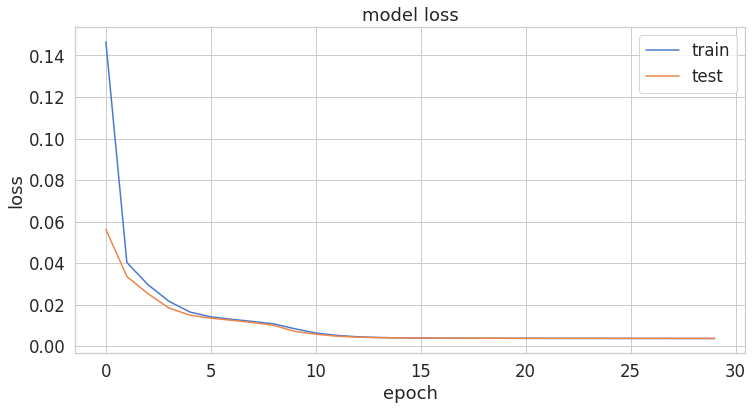

In [13]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [14]:
autoencoder = load_model('model_seqs2.h5')
print(f'Min Loss:{np.min(history["loss"])}')

Min Loss:0.00381420087069273


In [15]:
#get the MSE error term
predictions = autoencoder.predict(scaled_seqs)
mse = np.mean(np.power(scaled_seqs - predictions, 2), axis=1)
print('MSE:', np.quantile(mse, 0.9999)) # => the 9999% quatile - only 0.0001% have error score higher than that

MSE: 0.1389976900920129


In [16]:

#encode all the data
encoded_seqs = encode_sequence_list(seqs_ds.iloc[:,0])
#scale it
scaled_data = MinMaxScaler().fit_transform(encoded_seqs)
#predict it
predicted = autoencoder.predict(scaled_data)
#get the error term
mse = np.mean(np.power(scaled_data - predicted, 2), axis=1)
#now add them to our data frame
seqs_ds['MSE'] = mse

In [17]:
display(seqs_ds)


,0,MSE
0,CDEA2OOO,0.002310
1,CBFE1WWL,0.004034
2,DCCD2OWM,0.000423
3,CFAC0POW,0.004191
4,FACC2ZLW,0.002698
...,...,...
25000,XYDC2DCA,0.232618
25001,TXSX1ABC,0.355796
25002,RNIU4XRE,0.129347
25003,AABDXUEI,0.003842


In [18]:

mse_threshold = np.quantile(seqs_ds['MSE'], 0.9999)
print(f'MSE 0.9999 threshhold:{mse_threshold}')

MSE 0.9999 threshhold:0.13899413278763298


In [19]:
seqs_ds['MSE_Outlier'] = 0
seqs_ds.loc[seqs_ds['MSE'] > mse_threshold, 'MSE_Outlier'] = 1

In [20]:
print(f"Num of MSE outlier:{seqs_ds['MSE_Outlier'].sum()}")

seqs_ds.iloc[25000:]

Num of MSE outlier:3


,0,MSE,MSE_Outlier
25000,XYDC2DCA,0.232618,1
25001,TXSX1ABC,0.355796,1
25002,RNIU4XRE,0.129347,0
25003,AABDXUEI,0.003842,0
25004,SDRAC5RF,0.148657,1
